<a href="https://colab.research.google.com/github/HimanshuP8983/Deep-Learning/blob/master/CamVid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)

In [4]:
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [5]:
path_lbl = path/'labels'
path_img = path/'images'

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_06180.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_01380.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_05730.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_00990_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_01200_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_06180_P.png')]

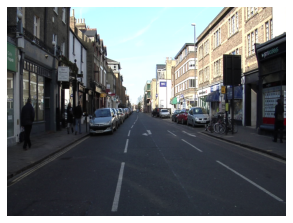

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

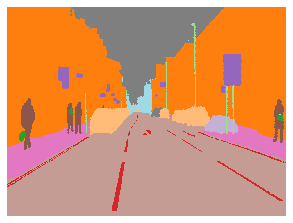

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5),alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [13]:
codes = np.loadtxt(path/'codes.txt',dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [14]:
size = src_size//2

free =gpu_mem_get_free_no_cache()
if free>8200:
  bs = 8
else:
  bs = 4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11430MB of GPU RAM free


In [15]:
src = (SegmentationItemList.from_folder(path_img).split_by_fname_file('../valid.txt').label_from_func(get_y_fn,classes=codes))

In [16]:
data = (src.transform(get_transforms(),size=size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats))

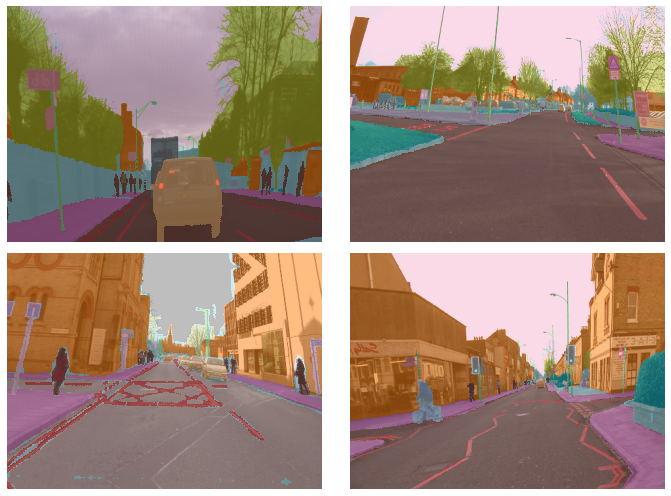

In [17]:
data.show_batch(2,figsize=(10,7))

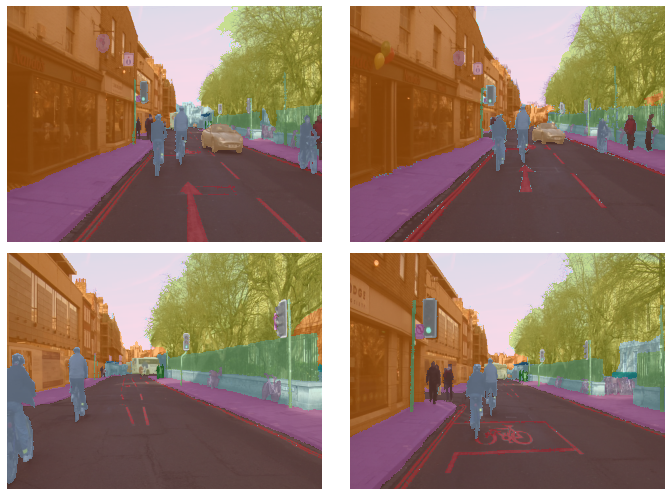

In [18]:
data.show_batch(2,figsize=(10,7),ds_type=DatasetType.Valid)

In [19]:
name2id  = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input,target):
  target=target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [20]:
metrics = acc_camvid

In [22]:
wd=1e-2

In [23]:
learn = unet_learner(data,models.resnet34,metrics=metrics,wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


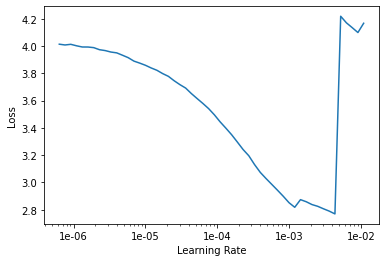

In [24]:
lr_find(learn)
learn.recorder.plot()

In [25]:
lr = 3e-3

In [27]:
learn.fit_one_cycle(3,slice(lr),pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.634753,0.654793,0.843192,03:21
1,1.690711,1.593997,0.566756,03:16
2,1.355820,1.201268,0.663486,03:16


In [28]:
learn.save('stage-1')

In [29]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

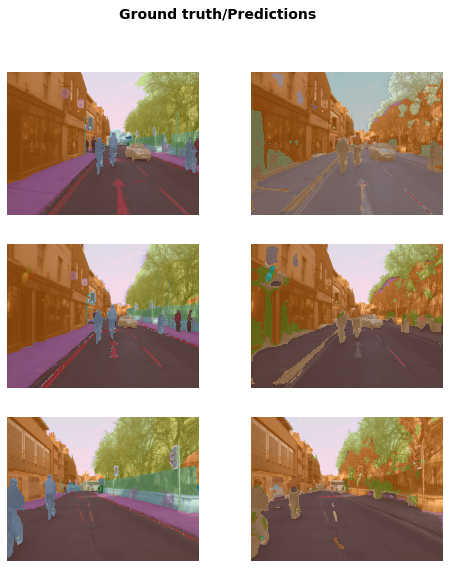

In [30]:
learn.show_results(rows=3,figsize=(8,9))

In [31]:
#learn.unfreeze()

In [ ]:
#lrs = slice(lr/400,lr/4)

In [ ]:
#learn.fit_one_cycle(12,lrs,pct_start=0.8)